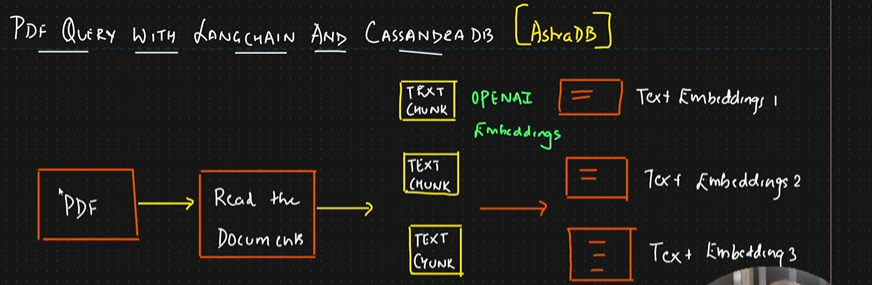

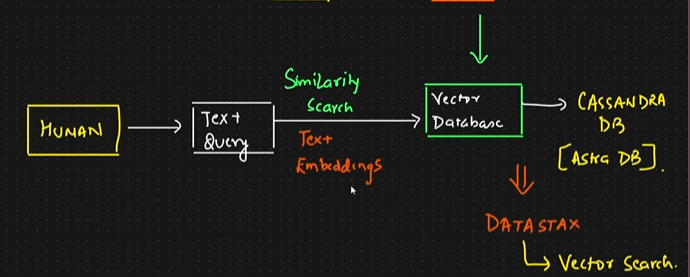

In [1]:
!pip install -q cassio datasets langchain openai tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 68.9 MB/s eta 0:00:00


In [4]:
!pip install -q langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00


## Install the Libraries

In [15]:
# LangChain components to use
from langchain_community.vectorstores import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
# VectorStoreIndexWrapper: it is gonna wrap all those particular vectors in one specific package so that it can be used quickly.
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings
# OpenAIEmbeddings will be responsible for converting text into vectors.

# Support for dataset retrieval with HuggingFace
from datasets import load_dataset

# With CassIO, the engine powering the Astra DB integration in LangChain,
# also initialize the DB connection:
import cassio

In [6]:
!pip install PyPDF2
# this will help you to read any text inside the PDF.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 12.4 MB/s eta 0:00:00


In [7]:
from PyPDF2 import PdfReader

## Setup


## Provide your secrets:
Replace the following with your Astra DB connection details and your OPENAI API key:

In [25]:
ASTRA_DB_APPLICATION_TOKEN = "" # enter the "AstraCS:..." string found in your Token JSON file
ASTRA_DB_ID = " " # Database ID

OpenAI_API_KEY =" "

In [26]:
# provide the path of pdf file/files
pdfreader = PdfReader("/content/drive/MyDrive/Colab Notebooks/myWork/PDF_Query_KrishNaik/Hands-On LLM O'REILLY.pdf")

In [27]:
from typing_extensions import Concatenate
# read text from pdf
raw_text = " "
for i, page in enumerate(pdfreader.pages):
  content = page.extract_text()
  if content:
    raw_text += content

In [28]:
raw_text

' Praise for Hands-On Large Language Models\nThis is an exceptional guide to the world of language models and their\npractical applications in industry . Its highly-visual coverage of\ngenerative, r epresentational, and r etrieval applications of language\nmodels empowers r eaders to quickly understand, use, and r efine LLMs.\nHighly r ecommended!\n—Nils Reimers, Director of Machine Learning at Cohere |\ncreator of sentence-transformers\nJay and Maarten have continued their tradition of pr oviding beautifully\nillustrated and insightful descriptions of complex topics in their new\nbook. Bolster ed with working code, timelines, and r eferences to key\npapers, their book is a valuable r esour ce for anyone looking to\nunderstand the main techniques behind how Lar ge Language Models ar e\nbuilt.\n—Andrew Ng, founder of DeepLearning.AI\nI can’ t think of another book that is mor e important to r ead right now . On\nevery single page, I learned something that is critical to success in this\

## Initialize the connection to your database:

In [29]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

## Create the LangChain embedding and LLM objects for later usage:

In [30]:
llm = OpenAI(openai_api_key=OpenAI_API_KEY)
embeddings = OpenAIEmbeddings(openai_api_key=OpenAI_API_KEY)

## Create your LangChain vectorstore...backed by Astra DB!

In [31]:
astra_vector_store = Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None
)

In [32]:
from langchain.text_splitter import CharacterTextSplitter
# We need to split the text using Character Text Split such that it should not increase token size
text_splitter = CharacterTextSplitter(
    separator= "\n",
    chunk_size=800,
    chunk_overlap=200,
    length_function=len
)
texts = text_splitter.split_text(raw_text)

In [33]:
texts[:50]

['Praise for Hands-On Large Language Models\nThis is an exceptional guide to the world of language models and their\npractical applications in industry . Its highly-visual coverage of\ngenerative, r epresentational, and r etrieval applications of language\nmodels empowers r eaders to quickly understand, use, and r efine LLMs.\nHighly r ecommended!\n—Nils Reimers, Director of Machine Learning at Cohere |\ncreator of sentence-transformers\nJay and Maarten have continued their tradition of pr oviding beautifully\nillustrated and insightful descriptions of complex topics in their new\nbook. Bolster ed with working code, timelines, and r eferences to key\npapers, their book is a valuable r esour ce for anyone looking to\nunderstand the main techniques behind how Lar ge Language Models ar e\nbuilt.',
 'papers, their book is a valuable r esour ce for anyone looking to\nunderstand the main techniques behind how Lar ge Language Models ar e\nbuilt.\n—Andrew Ng, founder of DeepLearning.AI\nI can’

## Load the dataset into the vectore store

In [35]:
astra_vector_store.add_texts(texts[:50])

print("Inserted %i headlines." % len(texts[:50]))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 50 headlines.


## Run the QA cycle
Simply run the cells and ask a question - or quit to stop.

In [38]:
first_question =True
while True:
  if first_question:
    query_text=input("\nEnter your question (or type 'quit' to exit):")
    first_question=False
  else:
    query_text=input("\nWhat's your next question (or type 'quit' to exit): ").strip()

  if query_text.lower()=="quit":
    break

  if query_text == "":
    continue

  first_question = False
  print("\nQUESTION: \"%s\"" % query_text)
  answer = astra_vector_index.query(query_text, llm=llm).strip()
  print("\nANSWER: \"%s\"" % answer)

  print("FIRST DOCUMENTS BY RELEVANCE")
  for doc, score in astra_vector_store.similarity_search_with_score(query_text, k=3):
    print(" [%0.4f] \"%s ...\"" % (score, doc.page_content[:84]))


Enter your question (or type 'quit' to exit):How Does the Tokenizer Break Down Text?

QUESTION: "How Does the Tokenizer Break Down Text?"



ANSWER: "The tokenizer breaks down the text by splitting it into individual words or subwords, also known as "tokens"."
FIRST DOCUMENTS BY RELEVANCE


 [0.9082] "Our history of Language AI starts with a technique called bag-of-words, a
method for ..."
 [0.9082] "Our history of Language AI starts with a technique called bag-of-words, a
method for ..."
 [0.9068] "to create individual words. However , this has its disadvantages as some
languages,  ..."

What's your next question (or type 'quit' to exit): quit
